 
L’objectif est d’identifier **au mieux** les clients à risque afin de proposer des actions préventives et améliorer la rétention.   


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, chi2 , f_classif, VarianceThreshold
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


#### Importation des données 

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

Analyse de la forme des données 

In [3]:
df = data.copy()

In [4]:
df.shape

(7043, 21)

<Axes: ylabel='count'>

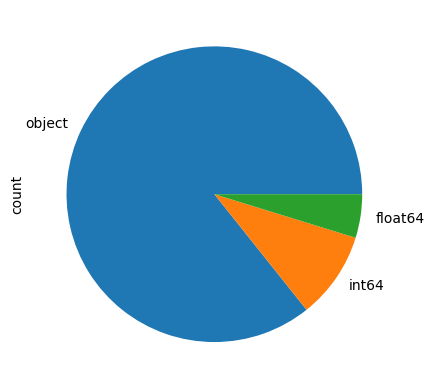

In [5]:
df.dtypes.value_counts().plot.pie()

#### Nettoyages de la data

In [6]:
df.drop(columns=["customerID"], inplace=True) # supression de la variable ID

In [7]:
print(pd.api.types.is_numeric_dtype(df['TotalCharges'])) # la variable totalcharge n'est pas numerique
# data["TotalCharges"].unique() : '29.85', '1889.5', '108.15', ..., '346.45'

False


Convertir la colonne TotalCharges en numerique

In [8]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

Suppresion des valeurs manquantes 

In [9]:
df.isna().sum()  # la variable total charge contient 11 valeurs manquantes

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
df.dropna(axis=0, inplace=True) # suppresion des valeurs manquantes

**Histogramme des variables continues**

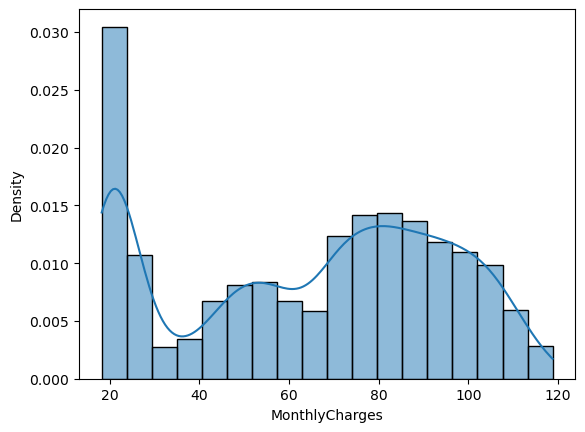

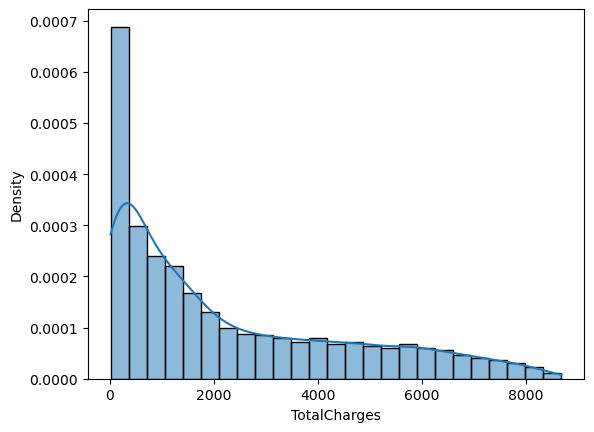

In [11]:
for col in df.select_dtypes('float'):    # mettre ce graphique en subplot
    plt.figure()
    sns.histplot(df[col], kde=True, stat="density")

<Axes: xlabel='tenure', ylabel='Count'>

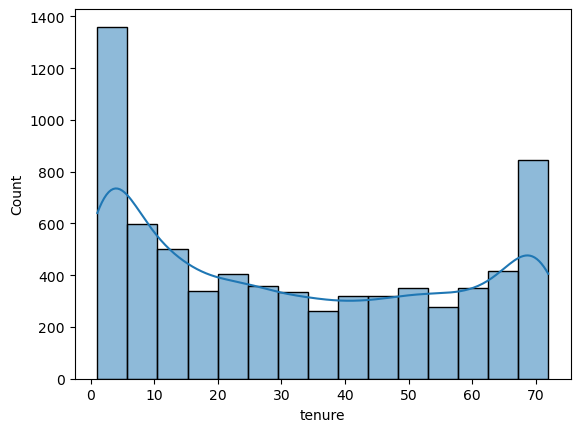

In [12]:
sns.histplot(df["tenure"],kde=True)

Variable Qualitative 

In [13]:
for col in df.select_dtypes('object'):
    print(f"{col :-<30} {df[col].unique()}")

gender------------------------ ['Female' 'Male']
Partner----------------------- ['Yes' 'No']
Dependents-------------------- ['No' 'Yes']
PhoneService------------------ ['No' 'Yes']
MultipleLines----------------- ['No phone service' 'No' 'Yes']
InternetService--------------- ['DSL' 'Fiber optic' 'No']
OnlineSecurity---------------- ['No' 'Yes' 'No internet service']
OnlineBackup------------------ ['Yes' 'No' 'No internet service']
DeviceProtection-------------- ['No' 'Yes' 'No internet service']
TechSupport------------------- ['No' 'Yes' 'No internet service']
StreamingTV------------------- ['No' 'Yes' 'No internet service']
StreamingMovies--------------- ['No' 'Yes' 'No internet service']
Contract---------------------- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling-------------- ['Yes' 'No']
PaymentMethod----------------- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn------------------------- ['No' 'Yes']


Bar plot des variable qualitatives 

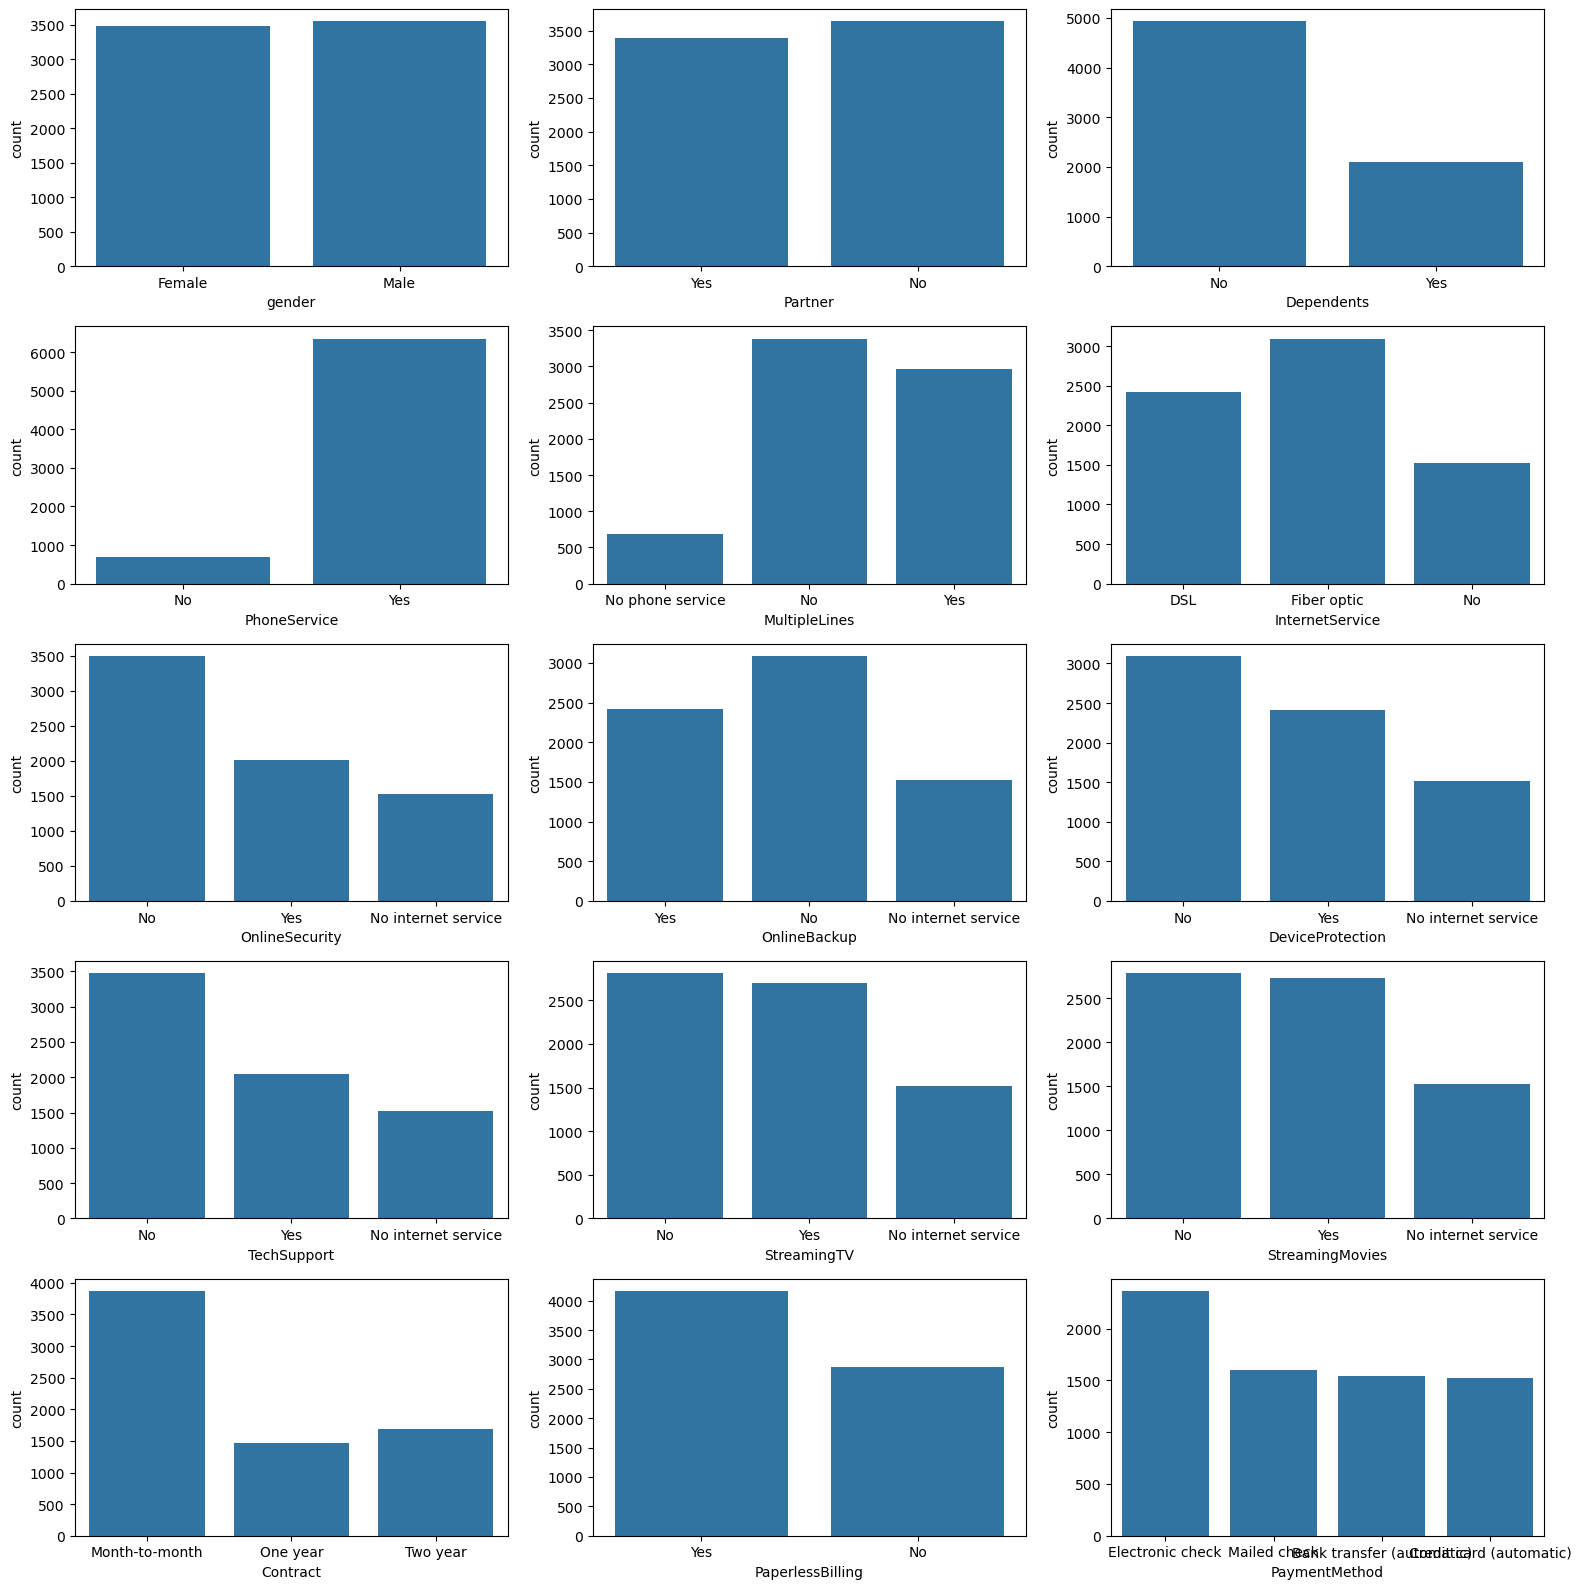

In [14]:
variable_categorielle = [col for col in df.select_dtypes('object')] 
fig, axes = plt.subplots(nrows=5,ncols=3, figsize=(16, 16))  
axes = axes.flatten()  
for ax, col in zip(axes, variable_categorielle):
    sns.countplot(data=df, x=col,ax=ax)

plt.tight_layout()  
plt.show() 

Relation target / Variables Continue

In [15]:
df_churn = df[df["Churn"]=="Yes"]
df_no_churn = df[df["Churn"]=="No"]

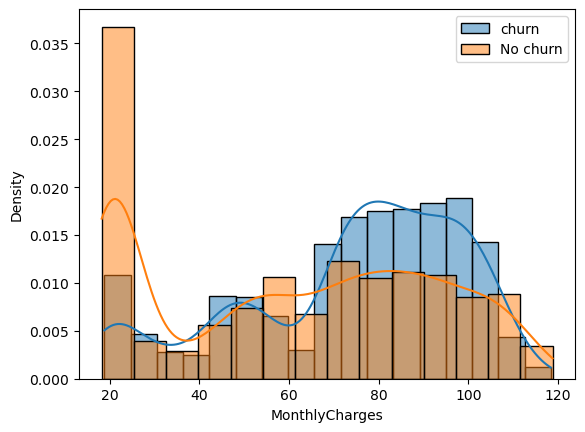

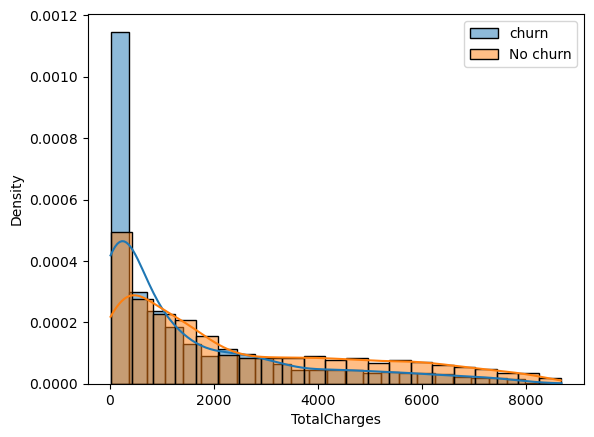

In [16]:
for col in df.select_dtypes('float'):    # mettre ce graphique en subplot
    plt.figure()
    sns.histplot(df_churn[col], kde=True, stat="density", label="churn")
    sns.histplot(df_no_churn[col], kde=True, stat="density", label="No churn")
    plt.legend()

Relation entre Target et le nombre de mois resté dans l'entreprise

<Axes: xlabel='tenure', ylabel='count'>

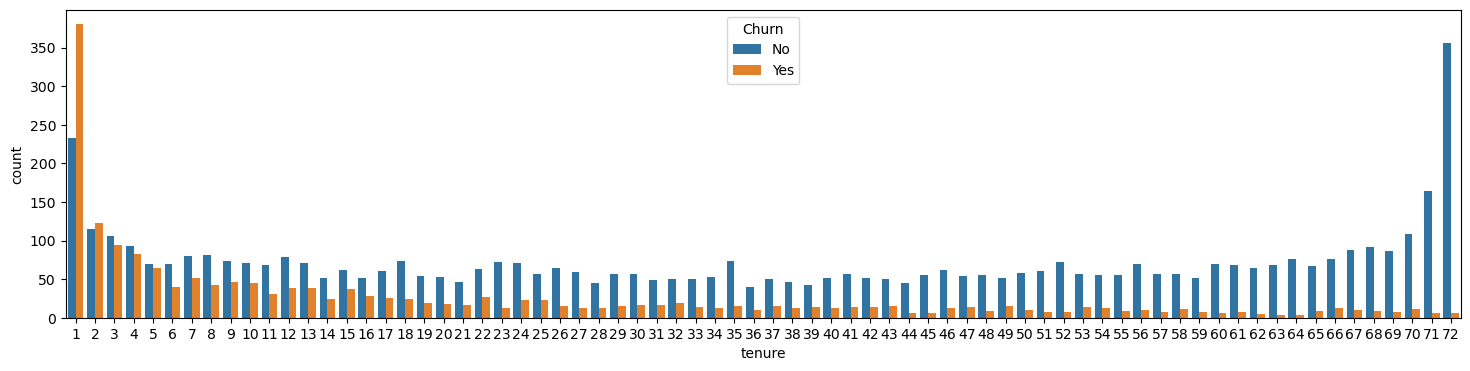

In [17]:
plt.figure(figsize=(18,4))
sns.countplot(data=df, x="tenure", hue="Churn")

Relation entre Target et les variables categorielles

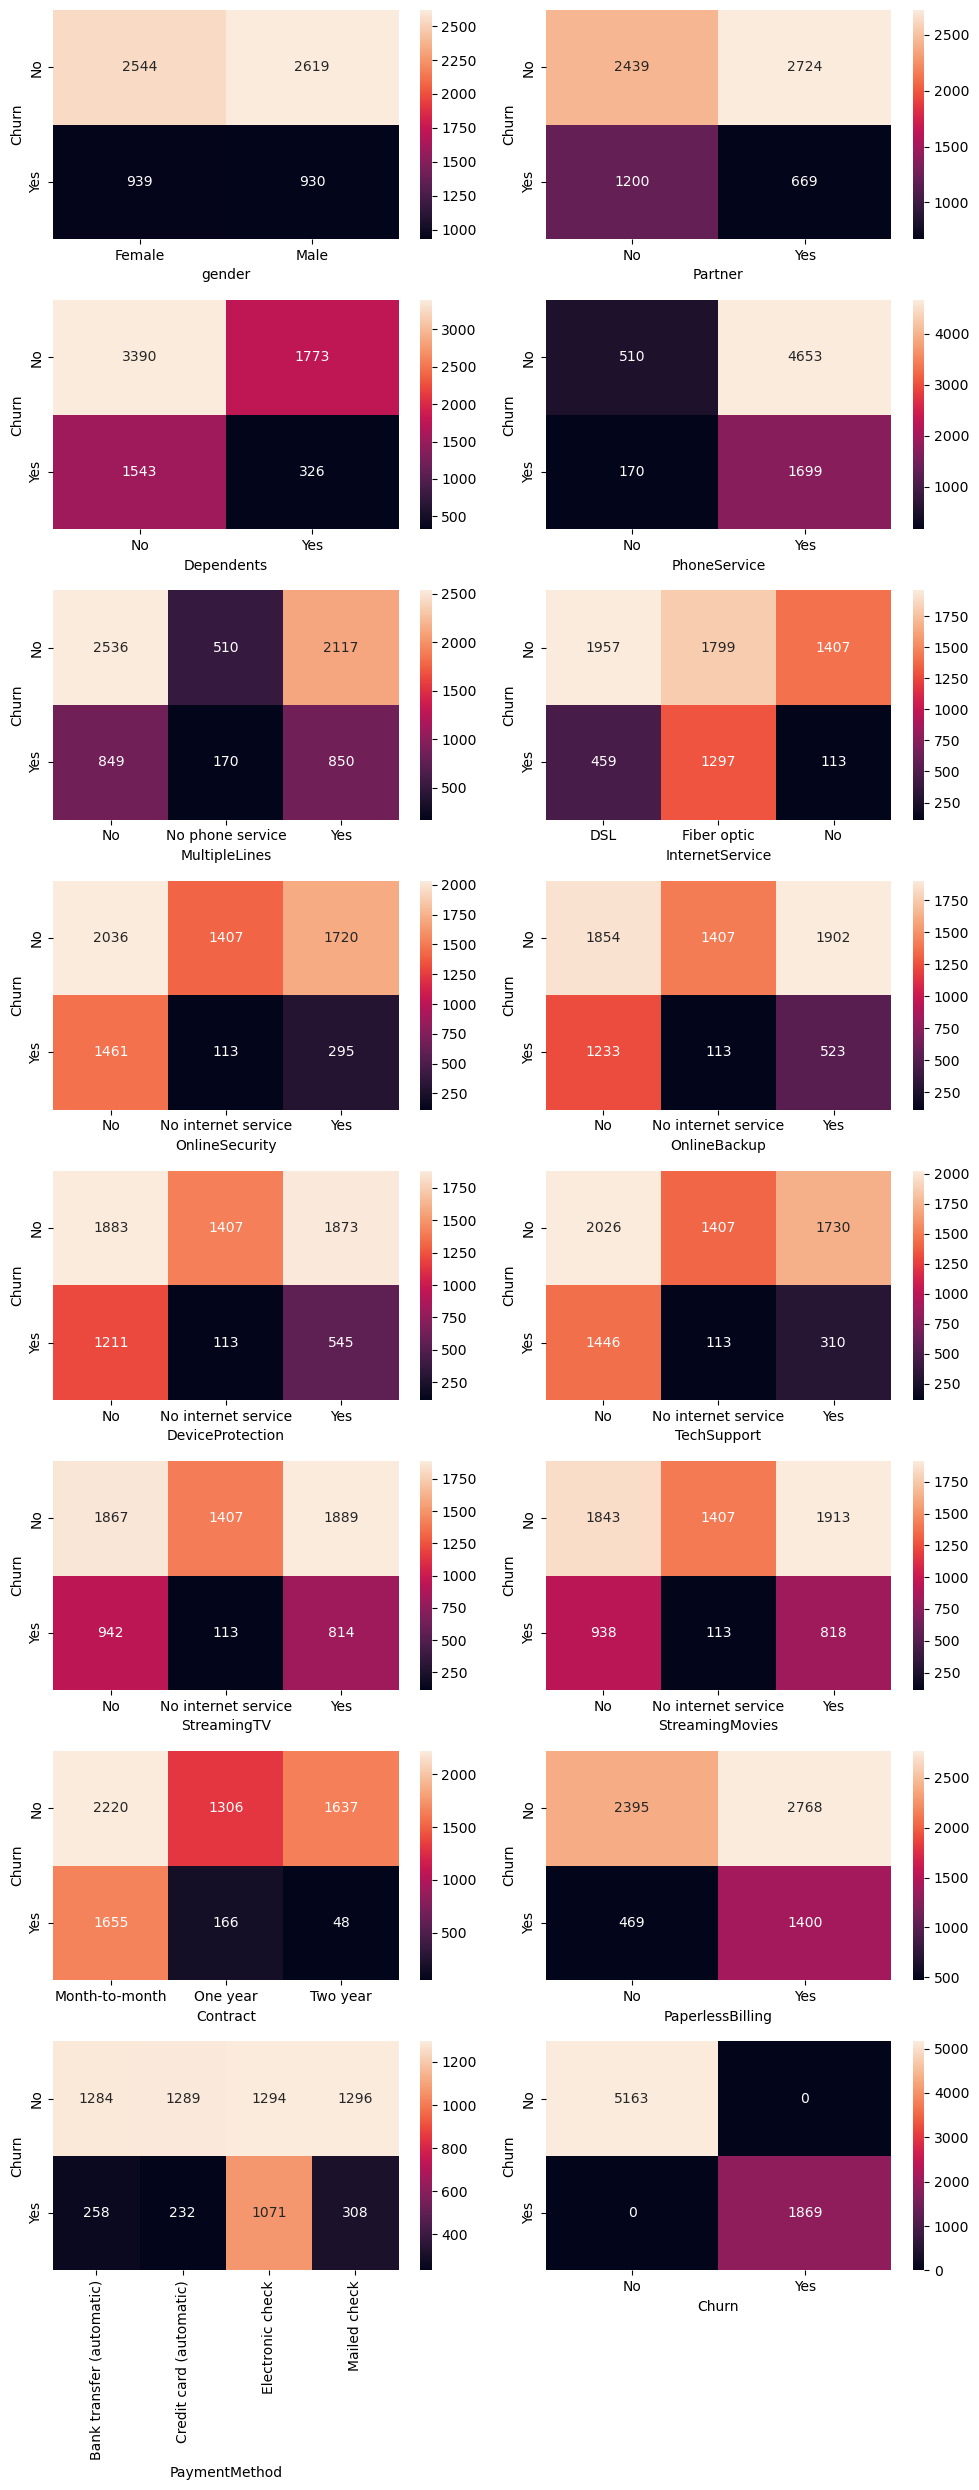

In [18]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10,25))
axes = axes.flatten()  
for ax, col in zip(axes, variable_categorielle):
    sns.heatmap(pd.crosstab(df["Churn"], df[col]), annot=True,fmt='d', ax=ax)
plt.tight_layout()  
plt.show()

### Test d'hypothses 

In [19]:
from scipy.stats import ttest_ind

Test de student 
  - Nous avons plus de 30 observation dans les deux classe 
  - Le montant des charges mensuelles pour les personnes qui churnent et ceux qui ne churnent pas sont independant

**Hypothèse 1** : Le montant des charges mensuelles pourrait influencer la résiliation    

Hypothèses :   

- H₀ (Hypothèse nulle) : Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas.   
- H₁ (Hypothèse alternative) : Il existe une différence significative entre ces montants.

In [20]:
print("H0:\" Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas.\"")
print()
alpha = 0.02
p_value = ttest_ind(df_churn["MonthlyCharges"], df_no_churn["MonthlyCharges"]).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:" Il n'y a pas de différence significative entre les montants moyens des charges mensuelles des clients qui churnent et ceux qui ne churnent pas."

Nous avons suffisamment d'evidences pour rejeter H0


⏩ Conclusion  Interprétation : Les personnes qui churnent ne paient pas en moyenne le même montant que celles qui ne churnent pas.

**Hypothèse 2** : La durée d'abonnement pourrait jouer un rôle dans le churn  
- Hypothèse nulle (H₀) : "Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas."
- Hypothèse alternative (H₁) : "La durée d'abonnement influence la résiliation du contrat."

In [21]:
print("H0:\"Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas.\"")
print()
alpha = 0.02
p_value = ttest_ind(df_churn["tenure"], df_no_churn["tenure"]).pvalue

if p_value < alpha :
    print("Nous avons suffisamment d'evidences pour rejeter H0")
else : 
    print("Nous n'avons pas suffisamment d'evidence pour rejeter H0") 

H0:"Il n'existe pas de différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas."

Nous avons suffisamment d'evidences pour rejeter H0


⏩  Conclusion :   
Il existe bien une différence significative entre la durée d'abonnement des clients qui résilient leur contrat et ceux qui ne le résilient pas.
Ainsi La durée d'abonnement pourrait jouer un rôle dans le churn

### Preprocessing 
1. Types de Variables 

 
**Variables ordinales (ordre hiérarchique)** 
- InternetService et Contract

  
**Variables catégorielles (nominales)**  
- Dependents, PhoneService, MultipleLines, OnlineSecurity
- OnlineBackup, DeviceProtection, TechSupport, StreamingTV
- StreamingMovies, PaperlessBilling, PaymentMethod, SeniorCitizen(0,1)


**Variables Continues**   
   * MonthlyCharges et TotalCharges

**Variables discrete** : 
- tenure
   


2. Encodage des variables et Normalisation 

In [50]:
# Onehot encoder
categorial_col = ["Dependents","gender","PhoneService", "MultipleLines","Partner","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "PaymentMethod"]


# Ordinale encoder 
ordinal_col = ["InternetService", "Contract"]
InternetService_order = ['No','DSL','Fiber optic']  # ordre
contract_order = ['Month-to-month', 'One year', 'Two year' ]

# colonne standard scaler = "TotalCharges"
col_standard = ["TotalCharges"]

# colonne min_max_scaler = "tenure" , ""MonthlyCharges"
col_min_max = ["tenure" , "MonthlyCharges"]
set_config(transform_output='pandas')

3. Construction des Pipelines

In [51]:
Encoder_ordinale_minmax = Pipeline(steps=[("Encoder_ordinale", OrdinalEncoder(categories=[InternetService_order,contract_order])),
                                           ("min_max",MinMaxScaler())])

columns_transformer_encoder_ordinal = ColumnTransformer(
    transformers=[                                                                        # afin d'eviter la multicolinéarité
        ("ordinale_min_max",Encoder_ordinale_minmax,ordinal_col)
    ],
    remainder="passthrough",
    verbose_feature_names_out = False
)
columns_transformer_encoder_ordinal

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinale_min_max',
                                 Pipeline(steps=[('Encoder_ordinale',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'DSL',
                                                                              'Fiber '
                                                                              'optic'],
                                                                             ['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['InternetService', 'Contract'])],
                  verbose_feature_names_out=False)

In [53]:
columns_transformer_encoder_cat = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, drop='first'),categorial_col) # drop="first" pour eliminé l'une des colonne afin d'eviter la multicolinéarité
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
columns_transformer_encoder_cat

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Dependents', 'gender', 'PhoneService',
                                  'MultipleLines', 'Partner', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'PaperlessBilling',
                                  'PaymentMethod'])],
                  verbose_feature_names_out=False)

In [61]:

Colonne_normaliser = ColumnTransformer(
    transformers=[
        ("col_standard_scaler", StandardScaler(), col_standard),
        ("col_min_max",MinMaxScaler(),col_min_max)
    ],
    remainder="passthrough",
    verbose_feature_names_out = False
)
Colonne_normaliser

ColumnTransformer(remainder='passthrough',
                  transformers=[('col_standard_scaler', StandardScaler(),
                                 ['TotalCharges']),
                                ('col_min_max', MinMaxScaler(),
                                 ['tenure', 'MonthlyCharges'])],
                  verbose_feature_names_out=False)

In [64]:

all_columns_transformer= ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(sparse_output=False, drop='first'),categorial_col),
    ("ordinale_min_max",Encoder_ordinale_minmax,ordinal_col),
    ("col_standard_scaler", StandardScaler(), col_standard),
    ("col_min_max",MinMaxScaler(),col_min_max)
]
)
all_columns_transformer

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Dependents', 'gender', 'PhoneService',
                                  'MultipleLines', 'Partner', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'PaperlessBilling',
                                  'PaymentMethod']),
                                ('ordinale_min_max',
                                 Pipeline(steps=[('Encoder_ordinale',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'DSL',
                                                                              'Fiber '
                                                                              'optic'],
                                                                             ['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']])),
                                                 ('min_max', MinMaxScaler())]),
                                 ['InternetService', 'Contract']),
                                ('col_standard_scaler', StandardScaler(),
                                 ['TotalCharges']),
                                ('col_min_max', MinMaxScaler(),
                                 ['tenure', 'MonthlyCharges'])])

In [66]:
preprocessor = make_pipeline(all_columns_transformer)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Dependents', 'gender',
                                                   'PhoneService',
                                                   'MultipleLines', 'Partner',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('ordinale_min_max',
                                                  Pipeline(steps=[('Encoder_ordinale',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'DSL',
                                                                                               'Fiber '
                                                                                               'optic'],
                                                                                              ['Month-to-month',
                                                                                               'One '
                                                                                               'year',
                                                                                               'Two '
                                                                                               'year']])),
                                                                  ('min_max',
                                                                   MinMaxScaler())]),
                                                  ['InternetService',
                                                   'Contract']),
                                                 ('col_standard_scaler',
                                                  StandardScaler(),
                                                  ['TotalCharges']),
                                                 ('col_min_max', MinMaxScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])]))])

#### Partionnement des données 

In [67]:
# pd.set_option('future.no_silent_downcasting', True)
df["Churn"] = df["Churn"].replace({"No": 0, "Yes": 1}).astype(int)
X,y = df.drop(columns="Churn", axis=1), df["Churn"]

In [68]:
y.value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

In [69]:
X=preprocessor.fit_transform(X)

**Alternative sans SMOTE**

In [72]:
# premiere alternative sans SMOTE , les resultats sont moins bons que avec smote 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=0, shuffle=True )


**Alternative avec Smote**
 - Les classes sont déséquilibrées, ce qui nécessite des techniques comme SMOTE ou un ajustement des poids

In [28]:
# # Donnée desequilibré , j'ai utilisé la methode SMOTE et cela fonctionne trés bien et donne des bonnes resultats
# 2. deuxieme alternative 
# smote = SMOTE(random_state=0)

# smote = SMOTE(random_state = 101)
# X_oversample, y_oversample = smote.fit_resample(X, y)
# X_train, X_test, y_train, y_test = train_test_split(X_oversample,y_oversample, test_size=0.2, random_state=0, shuffle=True )


In [73]:
print(f"{X_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(5625, 27)
X_test.shape=(1407, 27)
y_train.shape=(5625,)
y_test.shape=(1407,)


#### Modelisation et Procedure d'evaluation 

In [86]:
kbest_selection = SelectKBest(score_func=f_classif, k=15)
# preprocessor_finale = make_pipeline(kbest_selection) 
RandomForest = make_pipeline(kbest_selection,RandomForestClassifier(random_state=0))
SVM = make_pipeline(kbest_selection, SVC(random_state=0))
KNN = make_pipeline(kbest_selection, KNeighborsClassifier())
regression_log = make_pipeline(kbest_selection, LogisticRegression())

In [95]:
print(SVM)

Pipeline(steps=[('selectkbest', SelectKBest(k=15)),
                ('svc', SVC(random_state=0))])


In [96]:
def evaluation_courbe_apprentissage(model):
    
    # model.fit(X_train, y_train)
    # ypred = model.predict(X_test)
    
    # print(confusion_matrix(y_test, ypred))
    # print(classification_report(y_test, ypred))
    # print(ypred)
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(10, 4))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    


In [97]:
dict_of_models = {
    'RandomForest': RandomForest,
    'SVM' : SVM,
    'KNN' : KNN,
    'regression_log':regression_log
}

RandomForest
**************************************************
SVM
**************************************************
KNN
**************************************************
regression_log
**************************************************


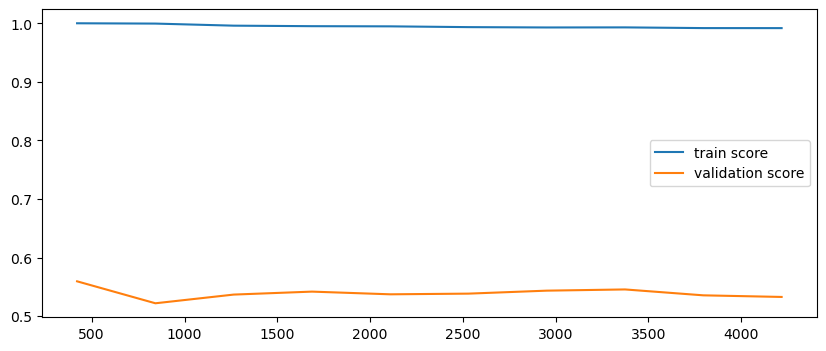

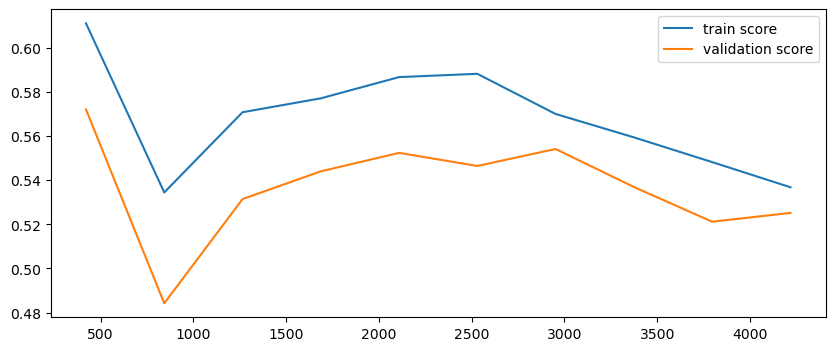

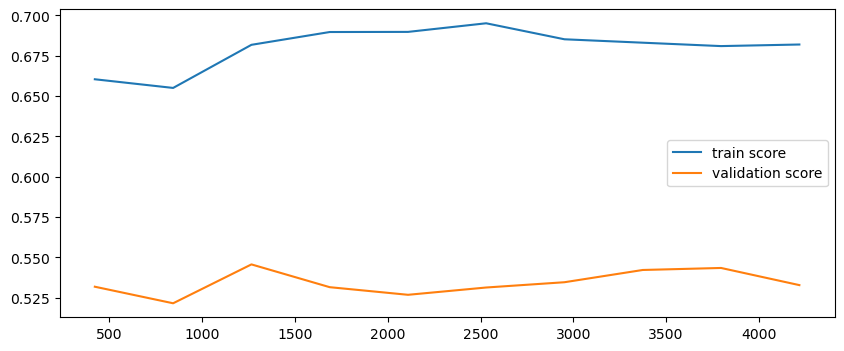

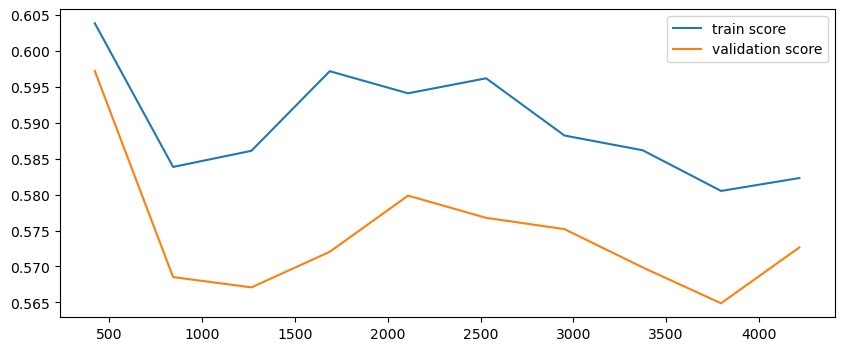

In [98]:
for name,model in dict_of_models.items():
    print(name)
    print(50*"*")
    evaluation_courbe_apprentissage(model)

#### Choix du meilleur modele et Optimisation de celeui-ci

In [111]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],  # 'kernel': ['linear', 'rbf'],'gamma': ['scale', 'auto'] autre parametre 
                'svc__C':[1,10,100,1000],
                'svc__kernel': ['linear', 'rbf', 'poly'],
                'selectkbest__k':range(4,20)}

In [ ]:
grid = RandomizedSearchCV(SVM, 
                          hyper_params,
                          scoring="recall",
                          n_iter=40,
                          cv=4)
grid.fit(X_train, y_train)
print(grid.best_params_)

In [104]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.56      0.60       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



Precision Recall Curve 

In [105]:
precision,recall,threshold = precision_recall_curve(y_test,grid.best_estimator_.decision_function(X_test))

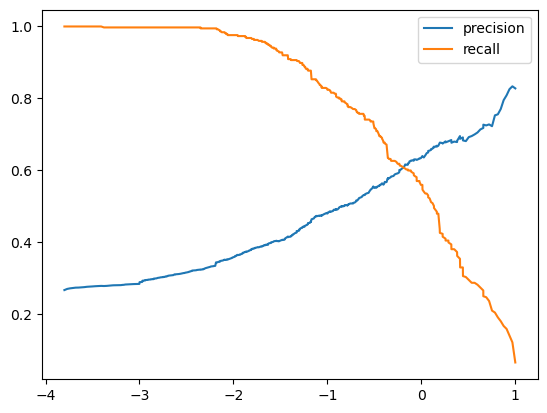

In [106]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

##### Evaluation Finale 

In [107]:
def model_final(model, X, threshold=0):
    return model.decision_function(X)>threshold

In [108]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-0.1)

In [109]:
print(f'{f1_score(y_test, y_pred)=}')
print(f"{recall_score(y_test, y_pred)=}")
print(f"{precision_score(y_test, y_pred)=}")

f1_score(y_test, y_pred)=0.6098901098901099
recall_score(y_test, y_pred)=0.5935828877005348
precision_score(y_test, y_pred)=0.6271186440677966


In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1033
           1       0.63      0.59      0.61       374

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.74      1407
weighted avg       0.79      0.80      0.80      1407

